# Thermohaline Group
OOI Data Labs Workshop - June 2019

**Working Title**: Exploring The Thermohaline Circulation (conveyor belt) and NADW Formation in the Irminger Sea with OOI Data

**Short Description**: Explore ocean and atmospheric processes that produce the cold, dense seawater in the Irminger Sea which drives the conveyor belt of the thermohaline circulation.  Use ocean and atmospheric surface conditions data across a number of seasonal cycles from the Irminger Sea to explore the role of atmospheric forcing on the production of North Atlantic Deep Water (NADW).

**Your Objective** (Challenge Question): How does the atmosphere influence the ocean to drive large-scale vertical circulation (ocean conveyor)?
1.	Make a prediction about how the SST(using 30 m depth as a proxy for the surface) responds to seasonal changes in wind forcing.
2.	Make a prediction about how the ocean surface water density changes in response to changes in the wind forcing.
3.	Make a prediction about how the water  temperature changes at various depths over the seasonal cycle.
4.	Make a prediction about how the surface water moves in response to changes in its density.
5.	Explore the data below to see what you can observe.

In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt

# Setup default plot styles
import seaborn as sns
sns.set()

# Others
# import pickle as pk
# import gc
# import pandas as pd
# !pip install cmocean
# import cmocean
# import numpy as np


## 1. Request Data from OOInet

Temperature and Density data from Irminger Sea Flanking Mooring B
* 30m - GI03FLMB-RIM01-02-CTDMOG060
* 90m - GI03FLMB-RIM01-02-CTDMOG063
* 350m - GI03FLMB-RIM01-02-CTDMOG067
* 1000m - GI03FLMB-RIM01-02-CTDMOH070

Also needed, surface wind speed data from ECMWF reanalysis from co-located gridpoint, because the METBK data is too gappy.

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# 30m
# request_data('GI03FLMB-RIM01-02-CTDMOG060','recovered_inst','ctdmo_ghqr_instrument_recovered')
# 90m
# request_data('GI03FLMB-RIM01-02-CTDMOG063','recovered_inst','ctdmo_ghqr_instrument_recovered','','')
# 350m
# request_data('GI03FLMB-RIM01-02-CTDMOG067','recovered_inst','ctdmo_ghqr_instrument_recovered','','')
# 1000m
# request_data('GI03FLMB-RIM01-02-CTDMOH070','recovered_inst','ctdmo_ghqr_instrument_recovered','','')


## 2. Load Data Files

In [0]:
ctd30 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190710T154700717Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
ctd90 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190710T154714533Z-GI03FLMB-RIM01-02-CTDMOG063-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
ctd350 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190710T154723294Z-GI03FLMB-RIM01-02-CTDMOG067-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
ctd1000 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190710T154733524Z-GI03FLMB-RIM01-02-CTDMOH070-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'

In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 100}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds


In [0]:
# Load the datasets
data30 = get_data(ctd30)
data90 = get_data(ctd90)
data350 = get_data(ctd350)
data1000 = get_data(ctd1000)

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 394 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 394 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 394 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 394 times more chunks
  return self.array[key]


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


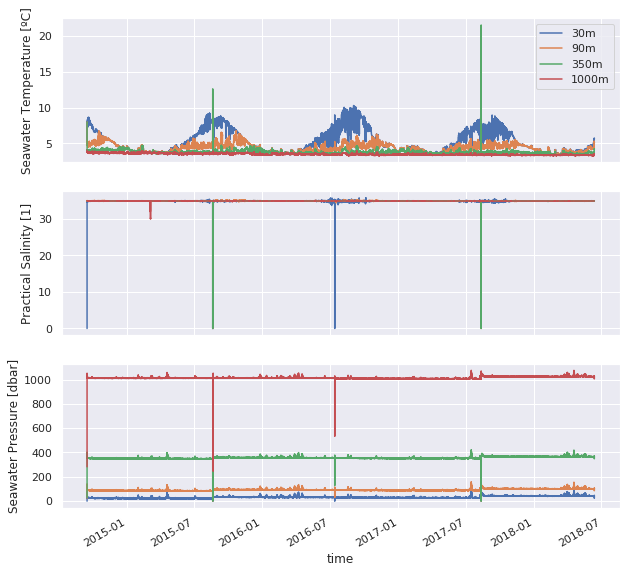

In [0]:
# Plot the data
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(10,9))
data30.ctdmo_seawater_temperature.plot(ax=ax1, label='30m')
data90.ctdmo_seawater_temperature.plot(ax=ax1, label='90m')
data350.ctdmo_seawater_temperature.plot(ax=ax1, label='350m')
data1000.ctdmo_seawater_temperature.plot(ax=ax1, label='1000m')
data30.practical_salinity.plot(ax=ax2)
data90.practical_salinity.plot(ax=ax2)
data350.practical_salinity.plot(ax=ax2)
data1000.practical_salinity.plot(ax=ax2)
data30.ctdmo_seawater_pressure.plot(ax=ax3)
data90.ctdmo_seawater_pressure.plot(ax=ax3)
data350.ctdmo_seawater_pressure.plot(ax=ax3)
data1000.ctdmo_seawater_pressure.plot(ax=ax3)

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.legend()

plt.savefig("irminger_ctd_raw.png");

## 3. Filter
As we can see from the above figure, there are some errant datapoints.  Let's filter them out.

In [0]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind


In [0]:
# Filter datasets
data90['ctdmo_seawater_temperature'] = data90['ctdmo_seawater_temperature'].where(reject_outliers(data90['ctdmo_seawater_temperature']))
data350['ctdmo_seawater_temperature'] = data350['ctdmo_seawater_temperature'].where(reject_outliers(data350['ctdmo_seawater_temperature']))

data30['practical_salinity'] = data30['practical_salinity'].where(reject_outliers(data30['practical_salinity']))
data90['practical_salinity'] = data90['practical_salinity'].where(reject_outliers(data90['practical_salinity']))
data350['practical_salinity'] = data350['practical_salinity'].where(reject_outliers(data350['practical_salinity']))
data1000['practical_salinity'] = data1000['practical_salinity'].where(reject_outliers(data1000['practical_salinity']))

data350['ctdmo_seawater_pressure'] = data350['ctdmo_seawater_pressure'].where(reject_outliers(data350['ctdmo_seawater_pressure']))
data1000['ctdmo_seawater_pressure'] = data1000['ctdmo_seawater_pressure'].where(reject_outliers(data1000['ctdmo_seawater_pressure']))

data30['density'] = data30['density'].where(reject_outliers(data30['density']))
data90['density'] = data90['density'].where(reject_outliers(data90['density']))
data350['density'] = data350['density'].where(reject_outliers(data350['density']))
data1000['density'] = data1000['density'].where(reject_outliers(data1000['density']))


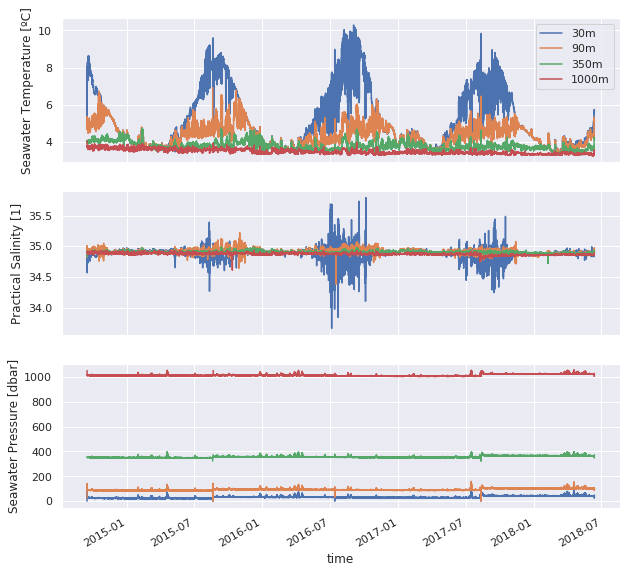

In [0]:
# Plot the data (again)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(10,9))
data30.ctdmo_seawater_temperature.plot(ax=ax1, label='30m')
data90.ctdmo_seawater_temperature.plot(ax=ax1, label='90m')
data350.ctdmo_seawater_temperature.plot(ax=ax1, label='350m')
data1000.ctdmo_seawater_temperature.plot(ax=ax1, label='1000m')
data30.practical_salinity.plot(ax=ax2)
data90.practical_salinity.plot(ax=ax2)
data350.practical_salinity.plot(ax=ax2)
data1000.practical_salinity.plot(ax=ax2)
data30.ctdmo_seawater_pressure.plot(ax=ax3)
data90.ctdmo_seawater_pressure.plot(ax=ax3)
data350.ctdmo_seawater_pressure.plot(ax=ax3)
data1000.ctdmo_seawater_pressure.plot(ax=ax3)

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.legend()

plt.savefig("irminger_ctd_cleaned.png");

## 4. Average
Next let's take a weekly running mean so that the data is slightly filtered.  
We'll also subset the dataset for simplicity.

In [0]:
# Averaging
avgint = '1W'
weekly_30m = data30[['practical_salinity','ctdmo_seawater_temperature', 'ctdmo_seawater_pressure', 'density']].resample(time=avgint).mean()
weekly_90m = data90[['practical_salinity','ctdmo_seawater_temperature', 'ctdmo_seawater_pressure', 'density']].resample(time=avgint).mean()
weekly_350m = data350[['practical_salinity','ctdmo_seawater_temperature', 'ctdmo_seawater_pressure', 'density']].resample(time=avgint).mean()
weekly_1000m = data1000[['practical_salinity','ctdmo_seawater_temperature', 'ctdmo_seawater_pressure', 'density']].resample(time=avgint).mean()


## 5. Potential Density
Next we need to convert to potential density. This removes the compressability effect on density so that we can compare density at different depths (pressures).

Here is the documentation for the [python seawater library](https://pythonhosted.org/seawater/index.html).  This library may be technically out of date, as the new [GSW-Python library](https://github.com/TEOS-10/GSW-Python) follows the TEOS-10 standard, but the differences are probably very minor for the purposes of this activity.

In [0]:
! pip install seawater
import seawater as sw

In [0]:
# Try with the potential desnisty function
# I'm not positive, but we may have to convert temperature to potential temperature first
# Had to switch T and S order
# Set pr = 0 to reference to the surface
den_30 = sw.pden(weekly_30m.practical_salinity, weekly_30m.ctdmo_seawater_temperature,  weekly_30m.ctdmo_seawater_pressure, pr=0)
den_90 = sw.pden(weekly_90m.practical_salinity, weekly_90m.ctdmo_seawater_temperature,  weekly_90m.ctdmo_seawater_pressure, pr=0)
den_350 = sw.pden(weekly_350m.practical_salinity, weekly_350m.ctdmo_seawater_temperature,  weekly_350m.ctdmo_seawater_pressure, pr=0)
den_1000 = sw.pden(weekly_1000m.practical_salinity, weekly_1000m.ctdmo_seawater_temperature,  weekly_1000m.ctdmo_seawater_pressure, pr=0)

# We ne to somehow keep the time index?
weekly_30m["pden"] = (['time'], den_30)
weekly_90m["pden"] = (['time'], den_90)
weekly_350m["pden"] = (['time'], den_350)
weekly_1000m["pden"] = (['time'], den_1000)

## 6. Atmospheric Data
Next we will load ECMWF wind & temp data using a local file on your Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/OOI Data Lab Workshop - June 2019 - Rutgers/Group Files: North Atlantic Circulation/' 

ecmwf = xr.open_dataset(path + '/ecmwf_winds.nc') 
ecmwf

<xarray.Dataset>
Dimensions:    (latitude: 3, longitude: 3, time: 3819)
Coordinates:
  * longitude  (longitude) float32 -40.0 -39.25 -38.5
  * latitude   (latitude) float32 60.5 59.75 59.0
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2018-06-15
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-07-01 16:11:51 GMT by grib_to_netcdf-2.12.0: grib_to_n...

In [0]:
# Subset to CTD dataset
ecmwf = ecmwf.sel(time=slice(data30.time.min(), data30.time.max()))

In [0]:
# Calculate the area mean surface conditions and filter in time

# 2m Air Temperature
mean_t2m = ecmwf.t2m.mean(dim = ('latitude', 'longitude')).resample(time=avgint).mean(dim = 'time') - 273.15 #convert from Kelvin

# 10m Winds
spd = (ecmwf.u10**2 + ecmwf.v10**2)**0.5
mean_wspd = spd.mean(dim = ('latitude', 'longitude')).resample(time=avgint).mean(dim = 'time') 

## 7. Bringing it all together

The 1000m potential density is included below, however the "fill_between" threshold is currently calculated between the 30m and 350m layer.

In Femka's paper they use a difference of 0.0025 kg /m^3.

From Nick: Rich and I didn't chat about it, but I think it was an oversight on our part not to include a temperature time series with the wind. It's the cold temperatures and the wind that extract heat from the ocean, cause the formation of densewaters, and the 'driving' of the overturning circulation (maybe, maybe not ... https://science.sciencemag.org/content/363/6426/516).  Anyway, we should have air temps in there. 

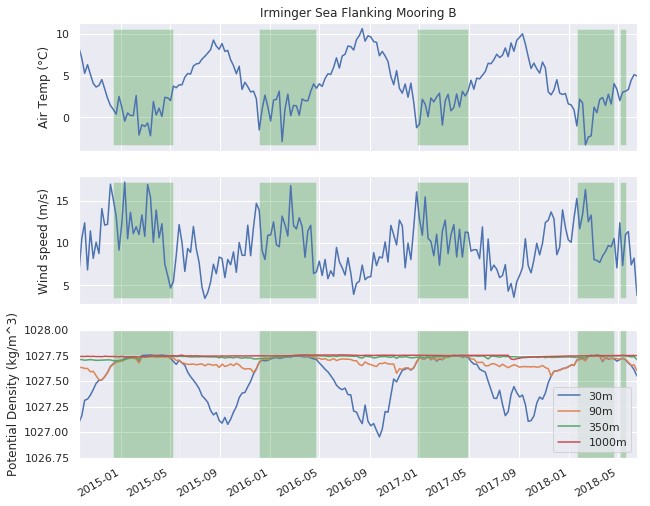

In [0]:
# Specify the density differences across the mixed layer
thresh_dens_diff = 0.05 

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
fig.set_size_inches(10,8)

# Temperature
mean_t2m.plot(ax=ax1)
ax1.set_ylabel('Air Temp (°C)')

# Winds
mean_wspd.plot(ax=ax2)
ax2.set_ylabel('Wind speed (m/s)')

# Density
weekly_30m.pden.plot(ax=ax3, label='30m')
weekly_90m.pden.plot(ax=ax3, label='90m')
weekly_350m.pden.plot(ax=ax3, label='350m')
weekly_1000m.pden.plot(ax=ax3, label='1000m')
ax3.set_ylim(1026.75, 1028)
ax3.set_xlim(weekly_30m.time.values.min(), weekly_30m.time.values.max())
ax3.set_ylabel('Potential Density (kg/m^3)')
ax3.legend()

# Highlight Periods
ax1.fill_between(weekly_30m.time.values, mean_t2m.min(), mean_t2m.max(), where=np.abs( weekly_350m.pden.values - weekly_30m.pden.values ) < thresh_dens_diff, facecolor='green', alpha=0.25)
ax2.fill_between(weekly_30m.time.values, mean_wspd.min(), mean_wspd.max(), where=np.abs( weekly_350m.pden.values - weekly_30m.pden.values ) <thresh_dens_diff, facecolor='green', alpha=0.25)
ax3.fill_between(weekly_30m.time.values, 1026.75, 1028, where=np.abs( weekly_350m.pden.values - weekly_30m.pden.values ) < thresh_dens_diff, facecolor='green', alpha=0.25)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.set_title('Irminger Sea Flanking Mooring B');

plt.savefig('irminger_thermohaline_'+avgint+'.png');

## 8. Merge and Export

In [0]:
# Merge the datasets
x = xr.Dataset({'temp_30m': weekly_30m.ctdmo_seawater_temperature, 
                'temp_90m': weekly_90m.ctdmo_seawater_temperature,
                'temp_350m': weekly_350m.ctdmo_seawater_temperature,
                'temp_1000m': weekly_1000m.ctdmo_seawater_temperature,
                'density_30m': weekly_30m.density, 
                'density_90m': weekly_90m.density,
                'density_350m': weekly_350m.density,
                'density_1000m': weekly_1000m.density,
                'potential_density_30m': weekly_30m.pden,
                'potential_density_90m': weekly_90m.pden,
                'potential_density_350m': weekly_350m.pden,
                'potential_density_1000m': weekly_1000m.pden,
                'wind_speed': mean_wspd,
                'air_temp': mean_t2m
               }).to_dataframe()
x.head()

,temp_30m,temp_90m,temp_350m,temp_1000m,density_30m,density_90m,density_350m,density_1000m,potential_density_30m,potential_density_90m,potential_density_350m,potential_density_1000m,wind_speed,air_temp
time,,,,,,,,,,,,,,
2014-09-21,8.209758,4.856796,4.007837,3.721467,1027.219599,1028.049238,1029.350706,1032.414111,1027.091992,1027.632552,1027.710010,1027.740591,6.536046,8.338715
2014-09-28,7.868330,4.883988,4.026345,3.726416,1027.283063,1028.043944,1029.343162,1032.409115,1027.161239,1027.631685,1027.708415,1027.740509,10.551082,7.069885
2014-10-05,7.059964,5.207111,4.155881,3.717852,1027.432995,1028.033699,1029.336189,1032.408517,1027.311399,1027.622313,1027.702810,1027.739392,12.375975,5.274567
2014-10-12,6.776806,5.048893,4.130833,3.758502,1027.436658,1028.025658,1029.330801,1032.403310,1027.322550,1027.622256,1027.705284,1027.742241,6.826221,6.314667
2014-10-19,6.649100,5.216252,4.027415,3.686232,1027.477825,1027.993547,1029.337127,1032.405282,1027.361524,1027.589291,1027.708466,1027.739702,11.426603,5.150452


In [0]:
# Export to CSV
x.to_csv('irminger_thermohaline_'+avgint+'.csv')

## Appendix - ECMWF Data
The ECMWF file was retrieved using: 
``` python
from ecmwfapi import ECMWFDataServer

server = ECMWFDataServer()

date = "2008-01-01/to/2018-06-15"
# date = "2008-01-01/to/2008-01-03"
# date = "2017-08-01/to/2017-08-03"
param = "10u/10v/2t"
# param = "2t"

server.retrieve({
  "class" : "ei",
  "dataset": "interim",
  "date" : date,
  "stream" : "oper",
  "expver" : "1",
  "levtype" : "sfc",
  "param" : param,
  "grid" : "0.75/0.75", #setting grid to ll or F128 causes interpolation but is required for area.
  "area" : "61/-40/59/-38",
  "time": "00:00:00",
  "step": "3",
  "format":"netcdf",
  "target" : "ecmwf_winds.nc",
})
```

From Nick: This takes a pretty long time for some reason. Did it on my local machine then put it in the drive. Just realized we don't need that whole time range. 